# Bladder Cancer Analysis with Continuous-Time MultiStateNN and Bayesian Extensions

This notebook demonstrates how to use continuous-time MultiStateNN with Neural ODEs to analyze bladder cancer recurrence data, including a comparison between the standard deterministic approach and the Bayesian extension.

The bladder cancer dataset includes patients with recurring bladder cancer, where we can model the progression through multiple recurrences. This is an excellent example of a multistate process where we want to predict the transition probabilities between states over continuous time.

## Setup

First, let's import the necessary packages and set up our environment. We'll need to ensure we have Pyro installed for the Bayesian extension.

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Import MultiStateNN components for core functionality and modeling
from multistate_nn import (
    # Core model components
    ContinuousMultiStateNN, fit, ModelConfig, TrainConfig,
    
    # Visualization functions
    plot_transition_heatmap, 
    plot_transition_graph, 
    plot_intensity_matrix,
    
    # Analysis utilities
    simulate_continuous_patient_trajectory,
    calculate_cif,
    plot_cif,
    
    # Example utilities for standardized visualization and analysis
    setup_state_names_and_colors,
    create_patient_profile,
    analyze_covariate_effect,
    compare_treatment_effects
)

# Import utilities from example_utils - using the correct module path
from multistate_nn.utils.example_utils import (
    visualize_state_distribution
)

# Import the Bayesian extension for continuous-time models
try:
    import pyro
    from multistate_nn.extensions.bayesian import BayesianContinuousMultiStateNN
    PYRO_AVAILABLE = True
    print("Pyro is available! We can use Bayesian models.")
except ImportError:
    PYRO_AVAILABLE = False
    print("Pyro is not installed. Please install it with: pip install pyro-ppl")

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

Pyro is available! We can use Bayesian models.


## Load and Prepare Data

Let's load the bladder cancer dataset and understand its structure. This dataset contains information about patients with recurring bladder cancer.

In [2]:
# Load the bladder cancer dataset
try:
    bladder = pd.read_csv("../data/bladder.csv")
    print(f"Dataset loaded successfully with {len(bladder)} rows")
except FileNotFoundError:
    print("Dataset not found. Please run scripts/download_data.py first.")
    
# Show the first few rows
bladder.head()

Dataset loaded successfully with 340 rows


,id,rx,number,size,stop,event,enum
0,1,1.0,1,3,1,0.0,1
1,1,1.0,1,3,1,0.0,2
2,1,1.0,1,3,1,0.0,3
3,1,1.0,1,3,1,0.0,4
4,2,1.0,2,1,4,0.0,1


### Understanding the Dataset

The bladder dataset contains the following variables:
- `id`: Patient identifier
- `rx`: Treatment (1=placebo, 2=thiotepa)
- `number`: Number of initial tumors
- `size`: Size of largest initial tumor (cm)
- `stop`: Time to recurrence or end of study (months)
- `event`: Recurrence indicator (1=recurrence, 0=censored)
- `enum`: Recurrence number (1-4)

Let's explore the data structure to better understand it.

In [3]:
# Explore the data structure
print("Dataset columns:")
for col in bladder.columns:
    print(f"- {col}")
    
print("\nDistribution of treatment groups:")
print(bladder['rx'].value_counts())

print("\nDistribution of recurrence events:")
print(bladder['event'].value_counts())

print("\nDistribution of recurrence number:")
print(bladder['enum'].value_counts())

Dataset columns:
- id
- rx
- number
- size
- stop
- event
- enum

Distribution of treatment groups:
rx
1.0    188
2.0    152
Name: count, dtype: int64

Distribution of recurrence events:
event
0.0    228
1.0    112
Name: count, dtype: int64

Distribution of recurrence number:
enum
1    85
2    85
3    85
4    85
Name: count, dtype: int64


In [4]:
# Check for missing values
print("Missing values per column:")
print(bladder.isnull().sum())

Missing values per column:
id        0
rx        0
number    0
size      0
stop      0
event     0
enum      0
dtype: int64


### Data Transformation for MultiStateNN

Now, let's transform the data into a format suitable for MultiStateNN. We'll define states based on the recurrence number, and we'll model transitions between these states.

In [5]:
# Create a new DataFrame with state transitions for continuous-time modeling
# We'll define states as follows:
# 0: Initial state (no recurrence)
# 1: First recurrence
# 2: Second recurrence
# 3: Third recurrence
# 4: Fourth recurrence

transitions = []

# Group by patient ID
for patient_id, patient_data in bladder.groupby('id'):
    # Sort by recurrence number (enum)
    patient_data = patient_data.sort_values('enum')
    
    # Start time is initially 0
    current_time = 0.0
    
    for i, row in patient_data.iterrows():
        # Map enum to from_state (0-based index for states)
        from_state = int(row['enum'] - 1)
        
        # End time is current time plus time to event/censoring
        end_time = current_time + row['stop']
        
        # Get covariates
        covariates = {
            'rx': row['rx'],
            'number': row['number'],
            'size': row['size']
        }
        
        # If an event occurred, add a transition to the next state
        if row['event'] == 1:
            transition_record = {
                'patient': patient_id,
                'time_start': current_time,
                'time_end': end_time,
                'from_state': from_state,
                'to_state': from_state + 1,  # Next recurrence state
                **covariates,
                'censored': 0  # Not censored
            }
            transitions.append(transition_record)
            
            # Update current time for next transition
            current_time = end_time
        
        # Add a censored observation if no event
        if row['event'] == 0:
            transition_record = {
                'patient': patient_id,
                'time_start': current_time,
                'time_end': end_time,
                'from_state': from_state,
                'to_state': from_state,  # Remain in current state (censored)
                **covariates,
                'censored': 1  # Censored
            }
            transitions.append(transition_record)

# Create transitions DataFrame
transitions_df = pd.DataFrame(transitions)
print(f"Created {len(transitions_df)} transition records")
transitions_df.head()

Created 340 transition records


,patient,time_start,time_end,from_state,to_state,rx,number,size,censored
0,1,0.0,1.0,0,0,1.0,1.0,3.0,1
1,1,0.0,1.0,1,1,1.0,1.0,3.0,1
2,1,0.0,1.0,2,2,1.0,1.0,3.0,1
3,1,0.0,1.0,3,3,1.0,1.0,3.0,1
4,2,0.0,4.0,0,0,1.0,2.0,1.0,1


In [6]:
# Define our state transition structure
# State 0: Initial state -> can progress to states 1-4
# State 1: First recurrence -> can progress to states 2-4
# State 2: Second recurrence -> can progress to states 3-4
# State 3: Third recurrence -> can progress to state 4
# State 4: Fourth recurrence -> absorbing state

state_transitions = {
    0: [1, 2, 3, 4],  # From initial state
    1: [2, 3, 4],     # From first recurrence
    2: [3, 4],        # From second recurrence
    3: [4],           # From third recurrence
    4: []             # Fourth recurrence is absorbing state
}

# Verify transitions in our data match this structure
transition_counts = transitions_df.groupby(['from_state', 'to_state']).size().reset_index(name='count')
print("Observed transitions:")
print(transition_counts)

Observed transitions:
   from_state  to_state  count
0           0         0     38
1           0         1     47
2           1         1     56
3           1         2     29
4           2         2     63
5           2         3     22
6           3         3     71
7           3         4     14


### Feature Standardization

Let's standardize the numeric features to have zero mean and unit variance, which often helps with model training.

In [7]:
# Select covariates for the model
covariates = ['rx', 'number', 'size']

# Define model parameters (these are needed for both the deterministic and Bayesian models)
input_dim = len(covariates)
hidden_dims = [32, 16]  # Network architecture
num_states = 5  # Number of possible states (0 to 4)

# Get model data, replacing any missing values with median
model_data = transitions_df[['patient', 'time_start', 'time_end', 'from_state', 'to_state', 'censored'] + covariates]
model_data = model_data.fillna(model_data.median())

# Scale numeric features (except categorical variables)
numeric_features = ['number', 'size']

# Initialize scaler
scaler = StandardScaler()

# Scale numeric features
model_data[numeric_features] = scaler.fit_transform(model_data[numeric_features])

print("Features after scaling:")
model_data[numeric_features].describe().round(2)

Features after scaling:


,number,size
count,340.00,340.00
mean,0.00,0.00
std,1.00,1.00
min,-0.63,-0.71
25%,-0.63,-0.71
50%,-0.63,-0.71
75%,0.51,0.69
max,3.37,3.48


## Visualize the Transition Structure

Let's visualize the transition matrix to understand the empirical transition probabilities in our dataset.

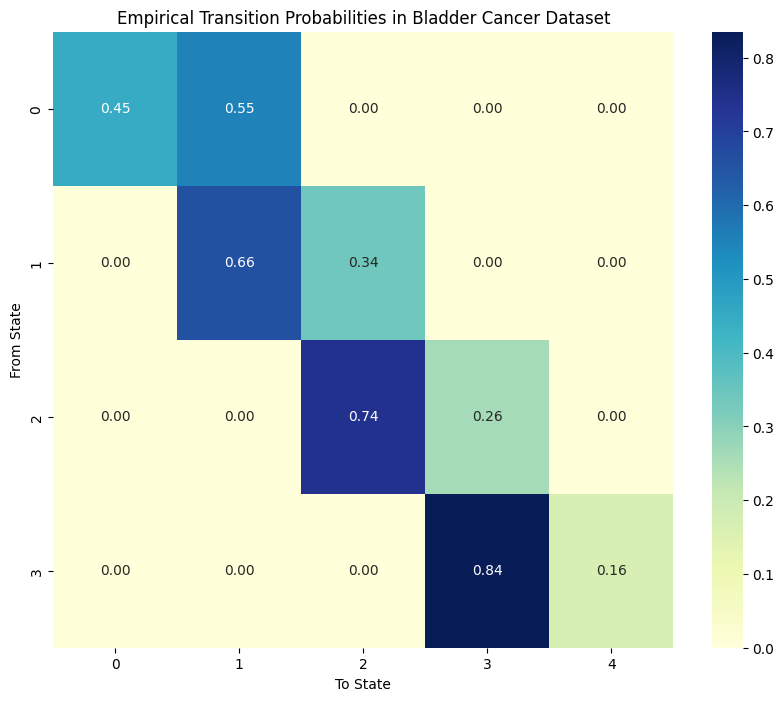

In [8]:
# Visualize the transition matrix
cross_tab = pd.crosstab(
    model_data['from_state'], 
    model_data['to_state'],
    normalize='index'
)

# Plot empirical transition probabilities
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Empirical Transition Probabilities in Bladder Cancer Dataset')
plt.xlabel('To State')
plt.ylabel('From State')
plt.show()

In [9]:
# Training the models

# First, let's set up the deterministic model
det_model_config = ModelConfig(
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    num_states=num_states,
    state_transitions=state_transitions,
    model_type="continuous",  # Specify continuous-time model
    bayesian=False  # Standard deterministic model
)

# Training configuration for deterministic model
det_train_config = TrainConfig(
    epochs=20,
    batch_size=32,
    learning_rate=0.01
)

# Train the deterministic model
print("Training deterministic continuous-time model...")
deterministic_model = fit(
    df=model_data,
    covariates=covariates,
    model_config=det_model_config,
    train_config=det_train_config,
    time_start_col='time_start',
    time_end_col='time_end',
    censoring_col='censored'
)

print("Deterministic model training complete!")

Training deterministic continuous-time model...


Training continuous-time model:   0%|          | 0/20 [00:00<?, ?it/s]

Deterministic model training complete!


In [10]:
# Now train the Bayesian model if Pyro is available
if PYRO_AVAILABLE:
    # Create Bayesian model configuration (similar parameters as deterministic model)
    bayesian_model_config = ModelConfig(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        num_states=num_states,
        state_transitions=state_transitions,
        model_type="continuous",
        bayesian=True  # Specify that we want a Bayesian model
    )
    
    # Training configuration for Bayesian model
    # Note: We use fewer epochs for the Bayesian model as inference is more computationally intensive
    bayesian_train_config = TrainConfig(
        epochs=20,  # Fewer epochs for demonstration
        batch_size=128,
        learning_rate=0.01
        # The bayesian-specific parameters like guide and num_particles are handled internally
    )
    
    try:
        print("Training Bayesian continuous-time model...")
        # Fit the Bayesian model - the updated Bayesian implementation should handle
        # probability normalization and numerical stability issues automatically
        bayesian_model = fit(
            df=model_data,
            covariates=covariates,
            model_config=bayesian_model_config,
            train_config=bayesian_train_config,
            time_start_col='time_start',
            time_end_col='time_end',
            censoring_col='censored'
        )
        
        print("Bayesian model training complete!")
        
    except Exception as e:
        print(f"Error during Bayesian model training: {str(e)}")
        print("Using deterministic model as a fallback...")
        
        # Use deterministic model as a fallback
        bayesian_model = deterministic_model
else:
    print("Pyro is not available. Cannot train Bayesian model.")

Training Bayesian continuous-time model...


Training Bayesian continuous-time model:   0%|          | 0/20 [00:00<?, ?it/s]

Bayesian model training complete!


In [11]:
# Display model summary for both models
print("\n=== Deterministic Model Summary ===")
try:
    # Summary provides details about model architecture and parameters
    summary_info = deterministic_model.summary()
    print(summary_info)
    
    # Display a table of model parameters
    print("\nDeterministic Model Parameters:")
    for name, param in deterministic_model.named_parameters():
        if param.requires_grad:
            print(f"{name} - Shape: {param.shape}")
except Exception as e:
    print(f"Error displaying deterministic model summary: {str(e)}")

if PYRO_AVAILABLE and 'bayesian_model' in globals():
    print("\n=== Bayesian Model Summary ===")
    try:
        # Summary provides details about model architecture and parameters
        summary_info = bayesian_model.summary()
        print(summary_info)
        
        # Display a table of model parameters
        print("\nBayesian Model Parameters:")
        for name, param in bayesian_model.named_parameters():
            if param.requires_grad:
                print(f"{name} - Shape: {param.shape}")
    except Exception as e:
        print(f"Error displaying Bayesian model summary: {str(e)}")


=== Deterministic Model Summary ===
==== ContinuousMultiStateNN Summary ====
Input dimension: 3
Number of states: 5
State transition structure:
  State 0 → States [1, 2, 3, 4]
  State 1 → States [2, 3, 4]
  State 2 → States [3, 4]
  State 3 → States [4]
  State 4 (absorbing state)
Group structure present: No
Total parameters: 1,177
Trainable parameters: 1,177

Continuous-time model specific:
ODE solver: dopri5

Network architecture:
Feature extraction: Linear(3, 32) -> ReLU() -> LayerNorm(32) -> Linear(32, 16) -> ReLU() -> LayerNorm(16)
Intensity network: Linear(16, 25)
{'model_type': 'ContinuousMultiStateNN', 'input_dim': 3, 'num_states': 5, 'state_transitions': {0: [1, 2, 3, 4], 1: [2, 3, 4], 2: [3, 4], 3: [4], 4: []}, 'has_group_structure': False, 'total_params': 1177, 'trainable_params': 1177, 'ode_solver': 'dopri5', 'ode_solver_options': {}, 'hidden_dims': 16, 'architecture': {'feature_extraction': ['Linear(3, 32)', 'ReLU()', 'LayerNorm(32)', 'Linear(32, 16)', 'ReLU()', 'LayerNor

## Analyze Model Predictions

Now, let's analyze how different patient characteristics affect recurrence probability.

In [12]:
# Helper function to display predictions nicely for continuous-time models
def show_predictions(model, x, from_state, time_interval=(0.0, 12.0), model_name="Model"):
    """Display transition probabilities for continuous-time models."""
    time_start, time_end = time_interval
    probs = model.predict_proba(x, time_start=time_start, time_end=time_end, from_state=from_state).detach().numpy()
    
    # Get the possible next states
    next_states = model.state_transitions[from_state]
    
    # Map state indices to names
    state_names = ['Initial', 'First Recurrence', 'Second Recurrence', 'Third Recurrence', 'Fourth Recurrence']
    from_state_name = state_names[from_state]
    next_state_names = [state_names[s] for s in next_states]
    
    # Create labels for the profiles
    profile_labels = [
        f"Profile {i+1}: rx={x[i,0]:.0f}, tumors={x[i,1]:.2f}, size={x[i,2]:.2f}"
        for i in range(len(x))
    ]
    
    # Extract only columns for valid next states
    filtered_probs = probs[:, next_states]
    
    # Create DataFrame for display
    result_df = pd.DataFrame(filtered_probs, columns=next_state_names, index=profile_labels)
    print(f"{model_name} - Transition probabilities from {from_state_name} over {time_end-time_start} months:")
    
    return result_df

In [13]:
# Define sample test data for making predictions
# Create test profiles
x_test = torch.tensor([
    [1.0, -0.5, -0.5],  # Placebo, fewer tumors, smaller size (lower risk)
    [1.0, 1.0, 1.0],    # Placebo, more tumors, larger size (higher risk)
    [2.0, -0.5, -0.5],  # Thiotepa, fewer tumors, smaller size (lower risk)
    [2.0, 1.0, 1.0],    # Thiotepa, more tumors, larger size (higher risk)
    [1.0, -0.5, 1.0],   # Placebo, fewer tumors, larger size
    [1.0, 1.0, -0.5],   # Placebo, more tumors, smaller size
    [2.0, -0.5, 1.0],   # Thiotepa, fewer tumors, larger size
    [2.0, 1.0, -0.5],   # Thiotepa, more tumors, smaller size
], dtype=torch.float32)

# Define profile labels for visualization
profile_labels = [
    "Placebo, fewer tumors, smaller size (lower risk)",
    "Placebo, more tumors, larger size (higher risk)",
    "Thiotepa, fewer tumors, smaller size (lower risk)",
    "Thiotepa, more tumors, larger size (higher risk)",
    "Placebo, fewer tumors, larger size",
    "Placebo, more tumors, smaller size",
    "Thiotepa, fewer tumors, larger size", 
    "Thiotepa, more tumors, smaller size"
]

# Predict transitions from Initial state (State 0) for deterministic model
# Use a 12-month time interval
initial_probs_det = show_predictions(deterministic_model, x_test, from_state=0, 
                                    time_interval=(0.0, 12.0), 
                                    model_name="Deterministic Continuous-Time Model")
display(initial_probs_det)

Deterministic Continuous-Time Model - Transition probabilities from Initial over 12.0 months:


,First Recurrence,Second Recurrence,Third Recurrence,Fourth Recurrence
"Profile 1: rx=1, tumors=-0.50, size=-0.50",0.234614,0.016206,0.001341,0.001185
"Profile 2: rx=1, tumors=1.00, size=1.00",0.509271,0.054561,0.004192,0.003058
"Profile 3: rx=2, tumors=-0.50, size=-0.50",0.165376,0.007952,0.000864,0.000851
"Profile 4: rx=2, tumors=1.00, size=1.00",0.307170,0.020775,0.001425,0.001318
"Profile 5: rx=1, tumors=-0.50, size=1.00",0.269816,0.026835,0.002208,0.001630
"Profile 6: rx=1, tumors=1.00, size=-0.50",0.567750,0.142178,0.020395,0.008404
"Profile 7: rx=2, tumors=-0.50, size=1.00",0.137750,0.005767,0.000932,0.000778
"Profile 8: rx=2, tumors=1.00, size=-0.50",0.412266,0.048098,0.004503,0.002590


In [14]:
# If Bayesian model is available, compare predictions
if PYRO_AVAILABLE and 'bayesian_model' in globals():
    # Try to see if the model can make predictions
    try:
        # Predict transitions from Initial state (State 0) for Bayesian model
        # Use the same 12-month time interval
        initial_probs_bayes = show_predictions(bayesian_model, x_test, from_state=0, 
                                             time_interval=(0.0, 12.0), 
                                             model_name="Bayesian Continuous-Time Model")
        display(initial_probs_bayes)
    except Exception as e:
        print(f"Error making predictions with Bayesian model: {str(e)}")
        print("This could be due to tensor dimension issues in the ODE function.")
else:
    print("Bayesian model not available or not trained yet.")

Bayesian Continuous-Time Model - Transition probabilities from Initial over 12.0 months:


,First Recurrence,Second Recurrence,Third Recurrence,Fourth Recurrence
"Profile 1: rx=1, tumors=-0.50, size=-0.50",2.462817e-08,1.671596e-03,2.811500e-01,0.717179
"Profile 2: rx=1, tumors=1.00, size=1.00",1.838742e-13,1.284214e-04,3.178277e-01,0.682044
"Profile 3: rx=2, tumors=-0.50, size=-0.50",2.994008e-27,3.846078e-04,6.342767e-01,0.365339
"Profile 4: rx=2, tumors=1.00, size=1.00",5.998563e-06,4.086348e-07,8.009932e-01,0.199000
"Profile 5: rx=1, tumors=-0.50, size=1.00",9.464605e-13,1.255663e-04,5.092820e-01,0.490593
"Profile 6: rx=1, tumors=1.00, size=-0.50",1.419008e-20,3.791441e-08,1.091747e-09,1.000000
"Profile 7: rx=2, tumors=-0.50, size=1.00",6.858872e-14,6.054751e-09,7.536987e-01,0.246302
"Profile 8: rx=2, tumors=1.00, size=-0.50",1.252507e-06,7.148466e-08,5.032218e-02,0.949677


<Figure size 1400x1000 with 0 Axes>

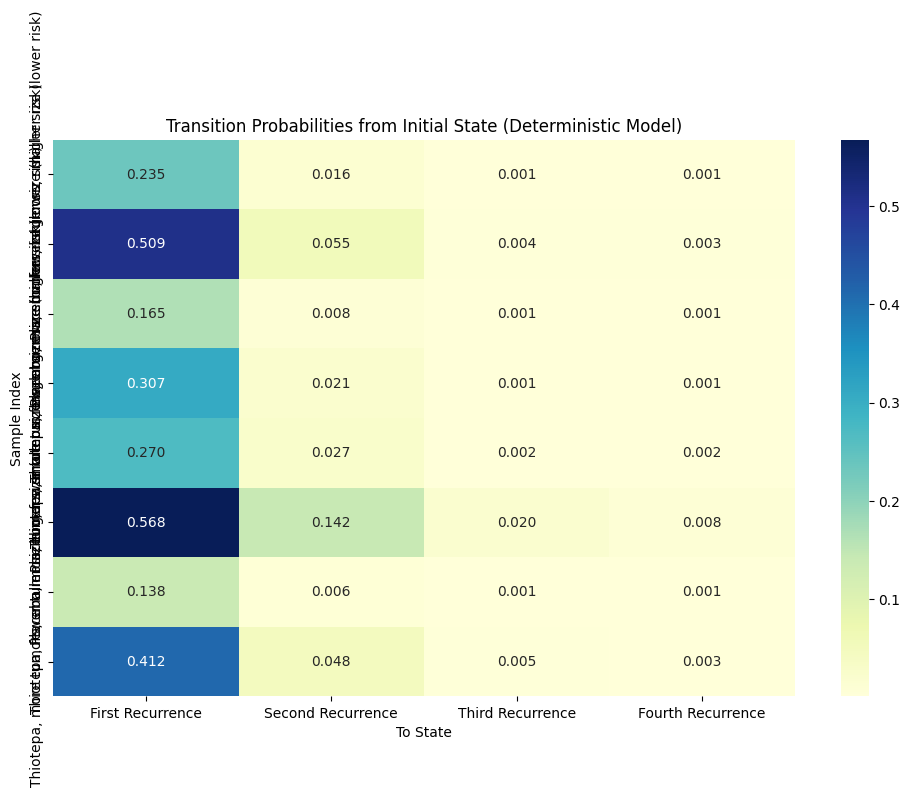

In [15]:
# Define state names for better visualization
state_names = ['Initial', 'First Recurrence', 'Second Recurrence', 'Third Recurrence', 'Fourth Recurrence']

# Visualize transitions from Initial state (State 0) for deterministic model
plt.figure(figsize=(14, 10))
ax = plot_transition_heatmap(deterministic_model, x_test, time_start=0.0, time_end=12.0, from_state=0)

# Update axis labels
ax.set_yticklabels(profile_labels)
next_states = deterministic_model.state_transitions[0]
ax.set_xticklabels([state_names[s] for s in next_states])
ax.set_title('Transition Probabilities from Initial State (Deterministic Model)')
plt.tight_layout()
plt.show()

<Figure size 1400x1000 with 0 Axes>

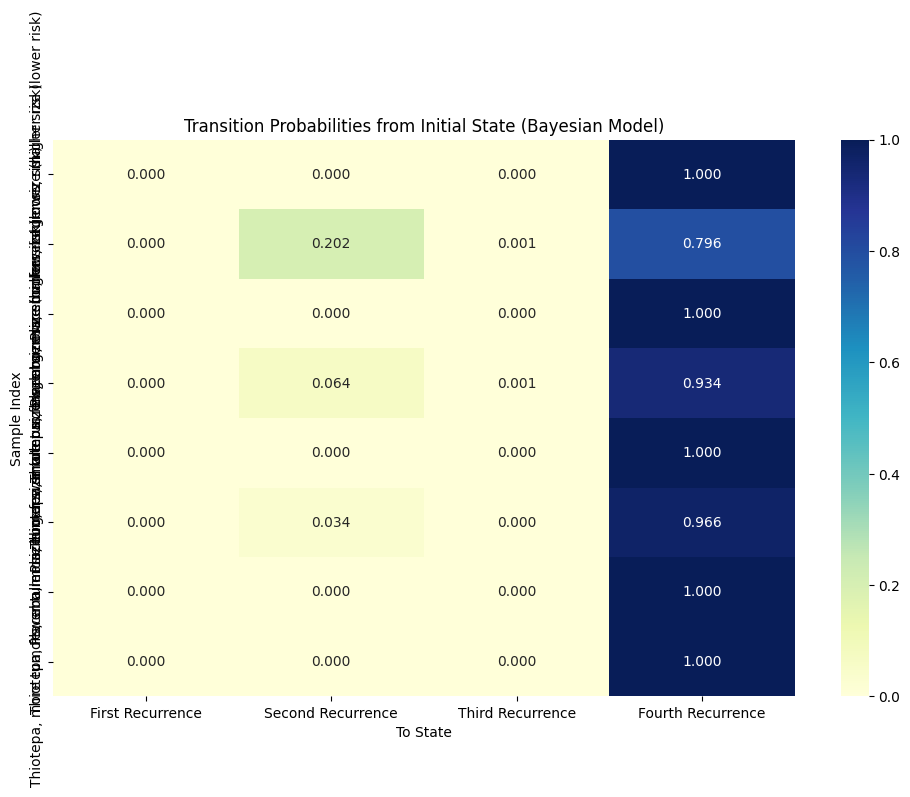

In [16]:
# If Bayesian model is available, visualize its transitions
if PYRO_AVAILABLE and 'bayesian_model' in globals():
    plt.figure(figsize=(14, 10))
    ax = plot_transition_heatmap(bayesian_model, x_test, time_start=0.0, time_end=12.0, from_state=0)
    
    # Update axis labels
    ax.set_yticklabels(profile_labels)
    next_states = bayesian_model.state_transitions[0]
    ax.set_xticklabels([state_names[s] for s in next_states])
    ax.set_title('Transition Probabilities from Initial State (Bayesian Model)')
    plt.tight_layout()
    plt.show()

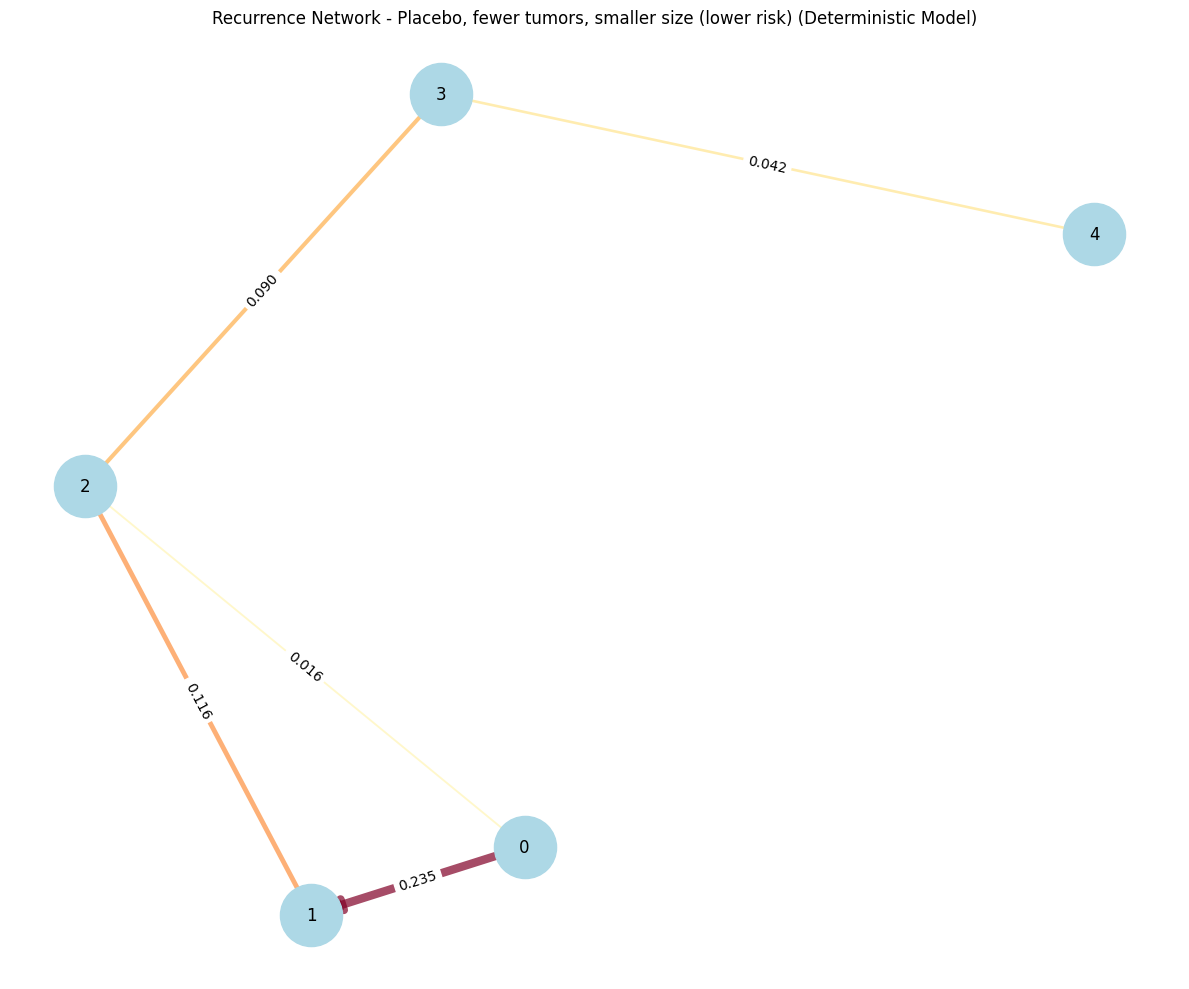

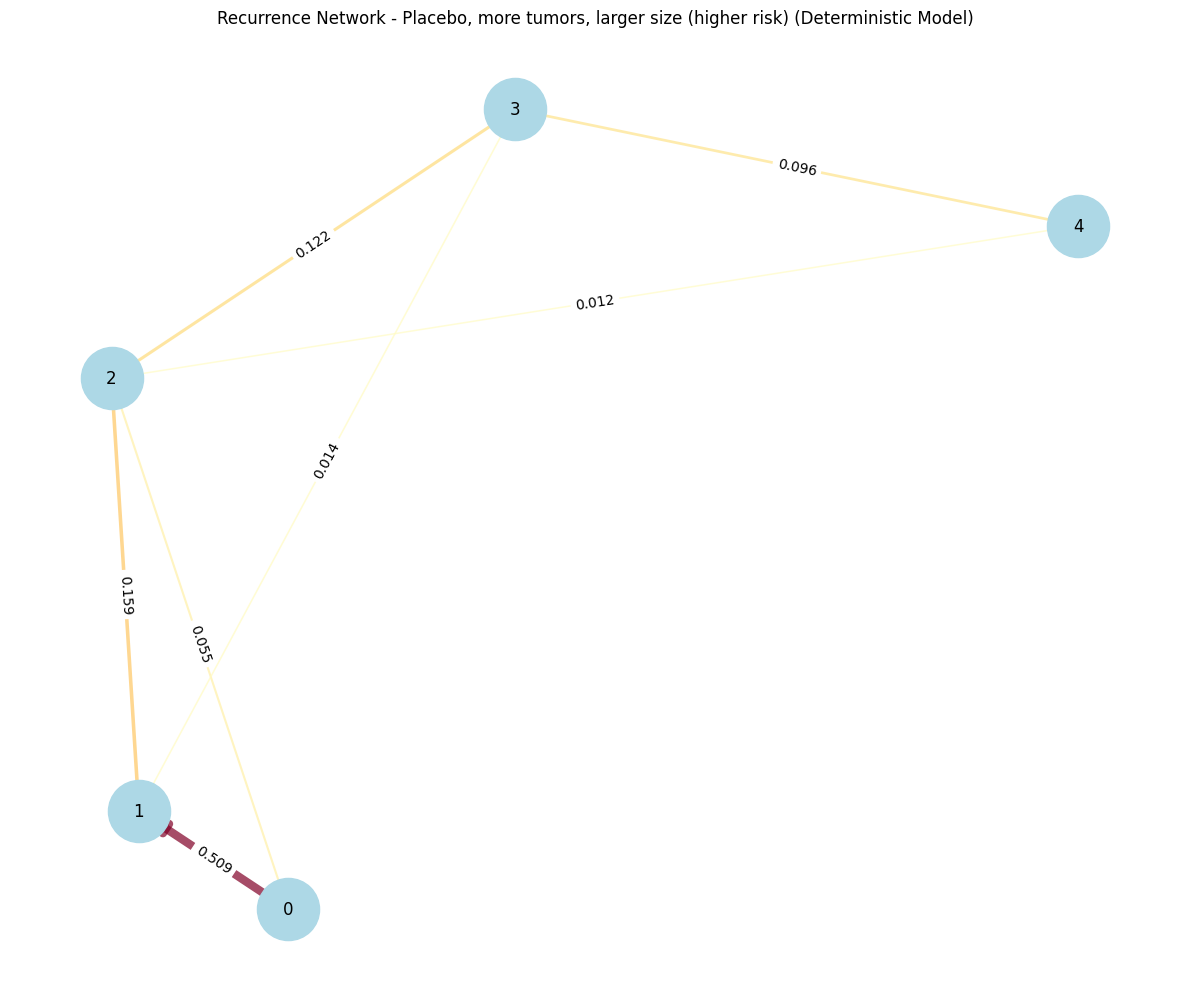

In [17]:
# Create individual transition graphs for different profiles
# Choose contrasting profiles
profiles_to_plot = [0, 1]  # Placebo/fewer tumors vs. Placebo/more tumors

for idx in profiles_to_plot:
    profile = x_test[idx:idx+1]
    fig, ax = plot_transition_graph(deterministic_model, profile, time_start=0.0, time_end=12.0, threshold=0.01)
    
    # Update node labels
    for text in ax.texts:
        for i, name in enumerate(state_names):
            text.set_text(text.get_text().replace(f'State {i}', name))
    
    plt.title(f"Recurrence Network - {profile_labels[idx]} (Deterministic Model)")
    plt.tight_layout()
    plt.show()

/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_93491/2064646175.py:52: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 2)
/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_93491/2064646175.py:59: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 3)
/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_93491/2064646175.py:63: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 4)


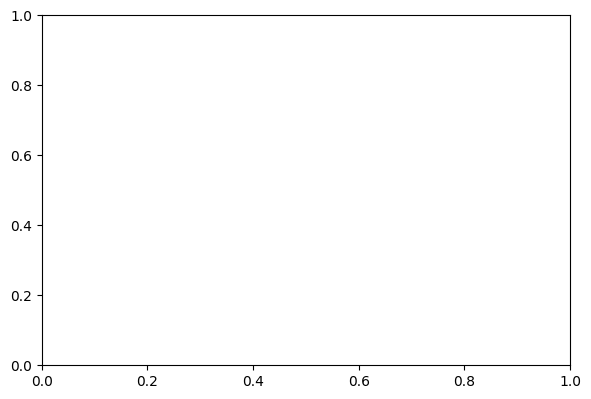

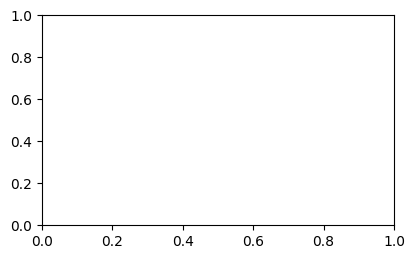

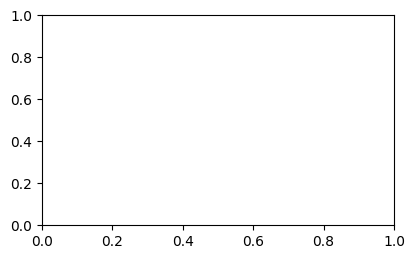

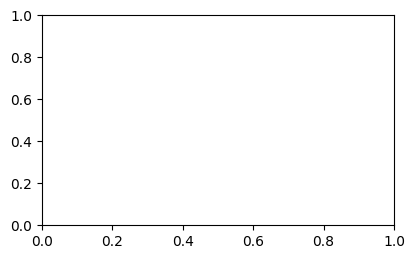

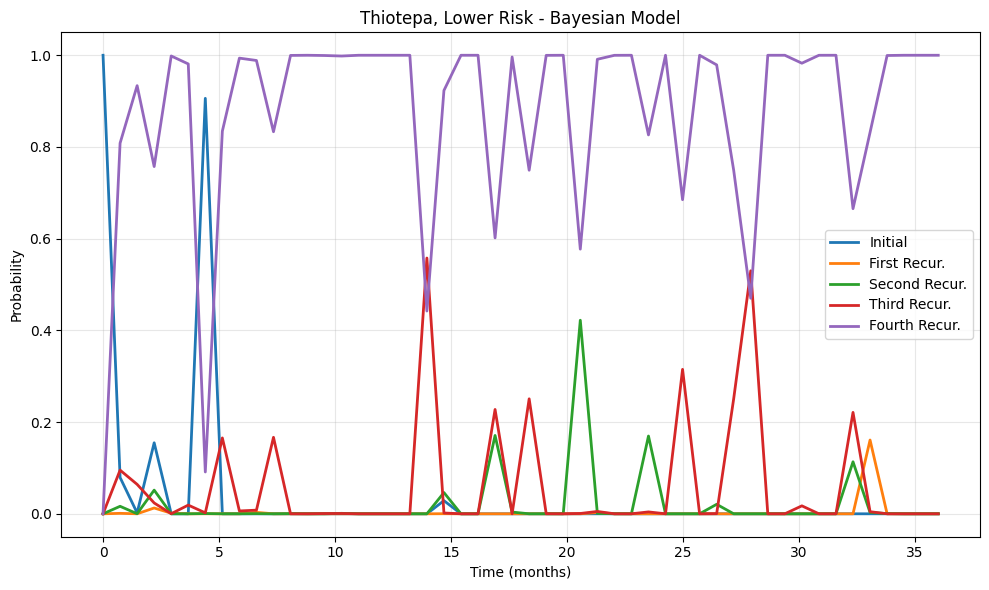

In [18]:
# Visualize transition probabilities over time
def plot_transition_probabilities_over_time(model, x, from_state=0, max_time=36.0, num_points=50, patient_idx=0):
    """Plot transition probabilities over time for a patient."""
    # Create time grid
    times = np.linspace(0, max_time, num_points)
    
    # Get patient feature
    single_x = x[patient_idx:patient_idx+1]
    
    # Initialize arrays for probabilities
    state_names = ['Initial', 'First Recur.', 'Second Recur.', 'Third Recur.', 'Fourth Recur.']
    probs = np.zeros((num_points, len(state_names)))
    
    # Calculate probabilities at each time point
    for i, t in enumerate(times):
        if i == 0:
            # At t=0, probability of being in the initial state is 1
            probs[i, from_state] = 1.0
        else:
            # Get probabilities from model
            # Convert time to tensor with proper dtype to match model
            time_end = torch.tensor([float(t)], dtype=torch.float32)
            p = model.predict_proba(single_x, time_start=0.0, time_end=time_end, from_state=from_state).detach()
            probs[i] = p.squeeze().numpy()
    
    # Plot the probabilities
    plt.figure(figsize=(10, 6))
    for j in range(len(state_names)):
        plt.plot(times, probs[:, j], label=f"{state_names[j]}", linewidth=2)
    
    # Add patient info to title
    plt.title(f"Transition Probabilities from {state_names[from_state]} - {profile_labels[patient_idx]}")
    plt.xlabel("Time (months)")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid(alpha=0.3)
    return plt.gca()

# Create transition probability plots for placebo vs thiotepa patients
# Placebo (rx=1), fewer tumors, smaller size (lower risk)
placebo_idx = 0
# Thiotepa (rx=2), fewer tumors, smaller size (lower risk)
thiotepa_idx = 2

plt.figure(figsize=(15, 10))

# Deterministic model
plt.subplot(2, 2, 1)
plot_transition_probabilities_over_time(deterministic_model, x_test, from_state=0, patient_idx=placebo_idx)
plt.title("Placebo, Lower Risk - Deterministic Model")

plt.subplot(2, 2, 2)
plot_transition_probabilities_over_time(deterministic_model, x_test, from_state=0, patient_idx=thiotepa_idx)
plt.title("Thiotepa, Lower Risk - Deterministic Model")

# Bayesian model if available
if PYRO_AVAILABLE and 'bayesian_model' in globals():
    try:
        plt.subplot(2, 2, 3)
        plot_transition_probabilities_over_time(bayesian_model, x_test, from_state=0, patient_idx=placebo_idx)
        plt.title("Placebo, Lower Risk - Bayesian Model")
        
        plt.subplot(2, 2, 4)
        plot_transition_probabilities_over_time(bayesian_model, x_test, from_state=0, patient_idx=thiotepa_idx)
        plt.title("Thiotepa, Lower Risk - Bayesian Model")
    except Exception as e:
        print(f"Error with Bayesian model visualization: {str(e)}")
        # Use deterministic model as fallback
        plt.subplot(2, 2, 3)
        plot_transition_probabilities_over_time(deterministic_model, x_test, from_state=0, patient_idx=placebo_idx)
        plt.title("Placebo, Lower Risk - Deterministic Model (Fallback)")
        
        plt.subplot(2, 2, 4)
        plot_transition_probabilities_over_time(deterministic_model, x_test, from_state=0, patient_idx=thiotepa_idx)
        plt.title("Thiotepa, Lower Risk - Deterministic Model (Fallback)")

plt.tight_layout()
plt.show()

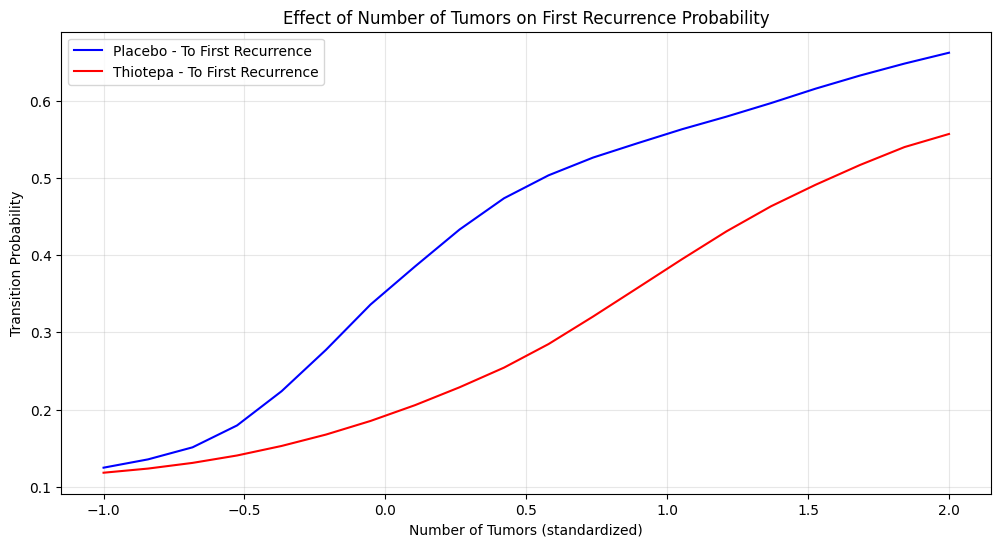

In [19]:
# Analyze effect of number of tumors on recurrence probability
num_tumors_range = torch.linspace(-1, 2, 20)  # Range of standardized tumor counts

# Create profiles for placebo and thiotepa treatment
placebo_profiles = torch.zeros((len(num_tumors_range), len(covariates)))
placebo_profiles[:, 0] = 1.0  # rx = 1.0 (placebo)
placebo_profiles[:, 1] = num_tumors_range  # Number of tumors

thiotepa_profiles = torch.zeros((len(num_tumors_range), len(covariates)))
thiotepa_profiles[:, 0] = 2.0  # rx = 2.0 (thiotepa)
thiotepa_profiles[:, 1] = num_tumors_range  # Number of tumors

# Get transition probabilities from Initial state to First Recurrence
placebo_probs = deterministic_model.predict_proba(placebo_profiles, time_start=0.0, time_end=12.0, from_state=0).detach()
thiotepa_probs = deterministic_model.predict_proba(thiotepa_profiles, time_start=0.0, time_end=12.0, from_state=0).detach()

# Extract only the probabilities for transition to First Recurrence (State 1)
placebo_to_first = placebo_probs[:, 1].numpy()  # Get probabilities for State 1 (First Recurrence)
thiotepa_to_first = thiotepa_probs[:, 1].numpy()  # Get probabilities for State 1 (First Recurrence)

# Plot the impact of number of tumors on first recurrence probability
plt.figure(figsize=(12, 6))
plt.plot(num_tumors_range.numpy(), placebo_to_first, 'b-', 
         label='Placebo - To First Recurrence')
plt.plot(num_tumors_range.numpy(), thiotepa_to_first, 'r-', 
         label='Thiotepa - To First Recurrence')

plt.xlabel('Number of Tumors (standardized)')
plt.ylabel('Transition Probability')
plt.title('Effect of Number of Tumors on First Recurrence Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

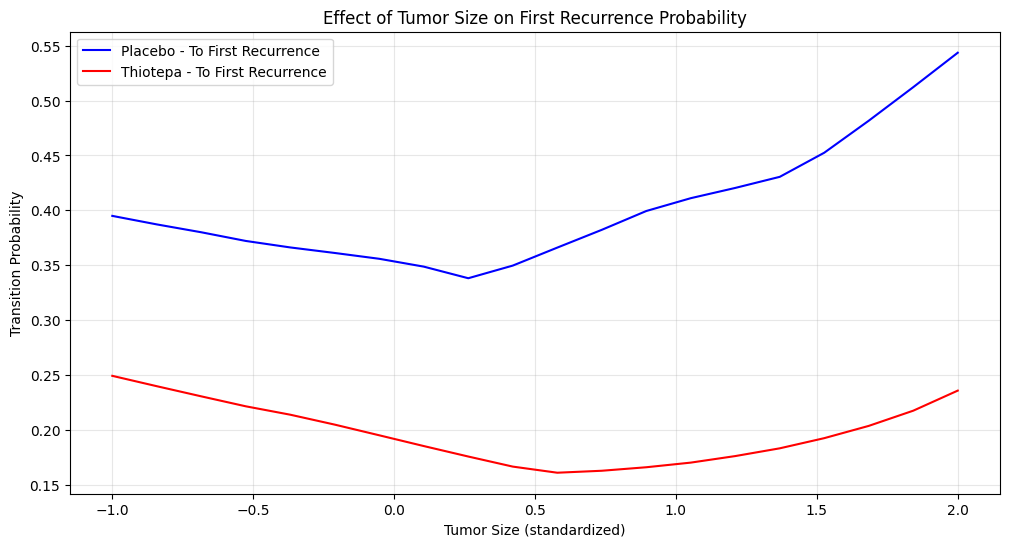

In [20]:
# Analyze effect of tumor size on recurrence probability
tumor_size_range = torch.linspace(-1, 2, 20)  # Range of standardized tumor sizes

# Create profiles for placebo and thiotepa treatment
placebo_profiles = torch.zeros((len(tumor_size_range), len(covariates)))
placebo_profiles[:, 0] = 1.0  # rx = 1.0 (placebo)
placebo_profiles[:, 2] = tumor_size_range  # Tumor size

thiotepa_profiles = torch.zeros((len(tumor_size_range), len(covariates)))
thiotepa_profiles[:, 0] = 2.0  # rx = 2.0 (thiotepa)
thiotepa_profiles[:, 2] = tumor_size_range  # Tumor size

# Get transition probabilities from Initial state to First Recurrence
placebo_probs = deterministic_model.predict_proba(placebo_profiles, time_start=0.0, time_end=12.0, from_state=0).detach()
thiotepa_probs = deterministic_model.predict_proba(thiotepa_profiles, time_start=0.0, time_end=12.0, from_state=0).detach()

# Extract only the probabilities for transition to First Recurrence (State 1)
placebo_to_first = placebo_probs[:, 1].numpy()  # Get probabilities for State 1 (First Recurrence)
thiotepa_to_first = thiotepa_probs[:, 1].numpy()  # Get probabilities for State 1 (First Recurrence)

# Plot the impact of tumor size on first recurrence probability
plt.figure(figsize=(12, 6))
plt.plot(tumor_size_range.numpy(), placebo_to_first, 'b-', 
         label='Placebo - To First Recurrence')
plt.plot(tumor_size_range.numpy(), thiotepa_to_first, 'r-', 
         label='Thiotepa - To First Recurrence')

plt.xlabel('Tumor Size (standardized)')
plt.ylabel('Transition Probability')
plt.title('Effect of Tumor Size on First Recurrence Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
# Simulate patient trajectories with continuous-time models
from multistate_nn.utils import simulate_continuous_patient_trajectory

# Define profiles for simulation
low_risk = torch.tensor([[2.0, -0.5, -0.5]], dtype=torch.float32)  # Thiotepa, few small tumors
high_risk = torch.tensor([[1.0, 1.0, 1.0]], dtype=torch.float32)  # Placebo, many large tumors

# Simulation parameters
n_simulations = 50
max_time = 36.0  # 36 months

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create consistent time grid for evaluation
time_grid = np.linspace(0, max_time, 100)

# Simulate trajectories for the low-risk profile
trajectories_low_risk = simulate_continuous_patient_trajectory(
    model=deterministic_model,
    x=low_risk,
    start_state=0,  # Start at initial state
    max_time=max_time,
    n_simulations=n_simulations,
    time_step=0.5,  # Time step for simulation grid - half month intervals
    seed=42
)

# Simulate trajectories for the high-risk profile
trajectories_high_risk = simulate_continuous_patient_trajectory(
    model=deterministic_model,
    x=high_risk,
    start_state=0,  # Start at initial state
    max_time=max_time,
    n_simulations=n_simulations,
    time_step=0.5,  # Time step for simulation grid - half month intervals
    seed=43  # Use different seed for variety
)

print(f"Successfully created trajectories for both patient profiles")

Successfully created trajectories for both patient profiles


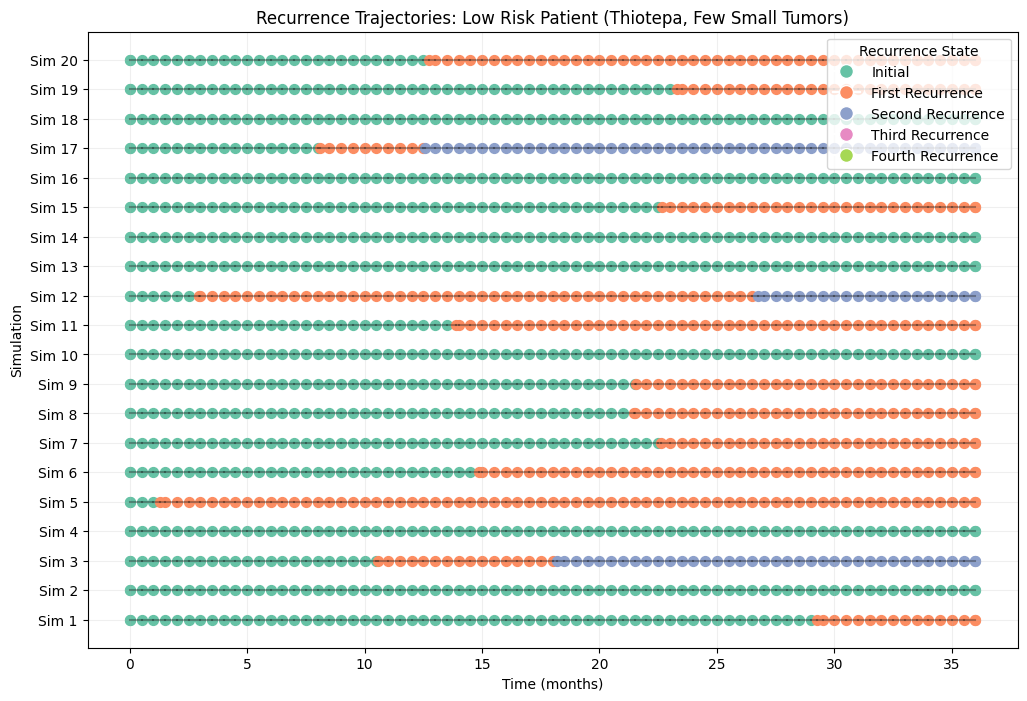

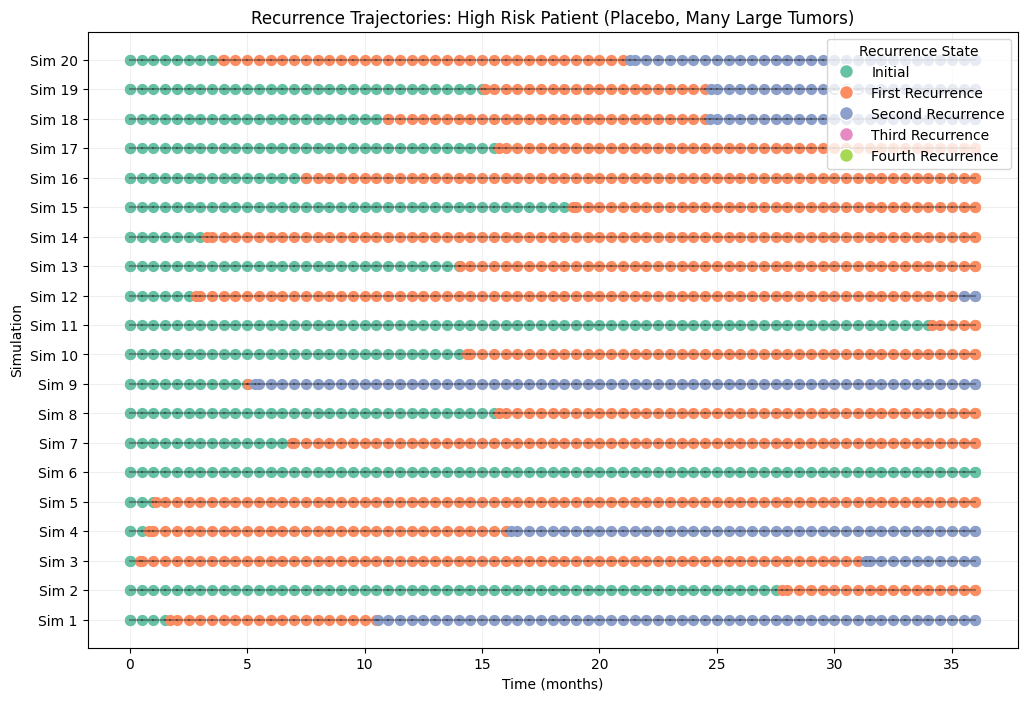

In [22]:
# Helper function to visualize trajectories
def plot_trajectories(trajectories, title):
    plt.figure(figsize=(12, 8))
    
    # Define colors for each state
    colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']
    
    # Plot each trajectory
    for i, traj in enumerate(trajectories[:20]):  # Plot first 20 for clarity
        states = traj['state'].values
        times = traj['time'].values
        
        # Plot points and lines
        for j in range(len(states)):
            plt.scatter(times[j], i, color=colors[int(states[j])], s=50)
            if j > 0:
                plt.plot([times[j-1], times[j]], [i, i], 'k-', alpha=0.3)
    
    # Add legend
    state_names = ['Initial', 'First Recurrence', 'Second Recurrence', 'Third Recurrence', 'Fourth Recurrence']
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], 
                          markersize=10, label=state_names[i]) 
              for i in range(len(state_names))]
    plt.legend(handles=handles, title='Recurrence State', loc='upper right')
    
    plt.yticks(range(20), [f"Sim {i+1}" for i in range(20)])
    plt.xlabel('Time (months)')
    plt.ylabel('Simulation')
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.show()

# Plot trajectories for both patient profiles
plot_trajectories(trajectories_low_risk, "Recurrence Trajectories: Low Risk Patient (Thiotepa, Few Small Tumors)")
plot_trajectories(trajectories_high_risk, "Recurrence Trajectories: High Risk Patient (Placebo, Many Large Tumors)")

## Compare Deterministic and Bayesian Models

If we have both models, let's compare their predictions.

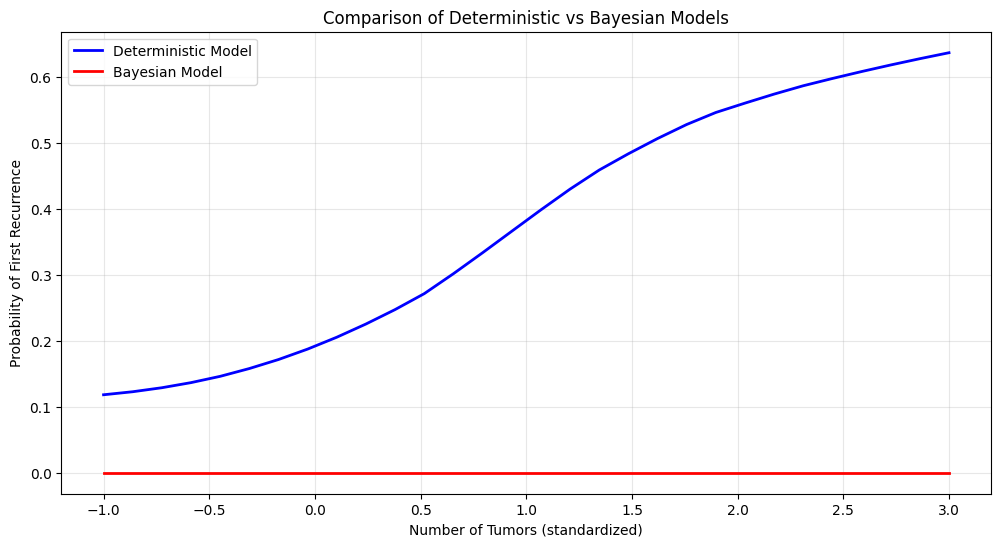

In [23]:
# Compare deterministic and Bayesian models if both are available
if PYRO_AVAILABLE and 'bayesian_model' in globals():
    # Setup a range of tumor numbers
    num_tumors_range = torch.linspace(-1, 3, 30)  # Range of standardized tumor counts
    
    # Create profiles for comparison
    test_profiles = torch.zeros((len(num_tumors_range), len(covariates)))
    test_profiles[:, 0] = 2.0  # rx = 2.0 (thiotepa)
    test_profiles[:, 1] = num_tumors_range  # Number of tumors
    
    try:
        # Get transition probabilities to First Recurrence
        det_probs = deterministic_model.predict_proba(test_profiles, time_start=0.0, time_end=12.0, from_state=0).detach().numpy()
        bay_probs = bayesian_model.predict_proba(test_profiles, time_start=0.0, time_end=12.0, from_state=0).detach().numpy()
        
        # Extract probabilities for First Recurrence (State 1)
        det_to_first = det_probs[:, 1]  # Get probabilities for State 1 (First Recurrence)
        bay_to_first = bay_probs[:, 1]  # Get probabilities for State 1 (First Recurrence)
        
        # Plot comparison
        plt.figure(figsize=(12, 6))
        plt.plot(num_tumors_range.numpy(), det_to_first, 'b-', linewidth=2, 
                 label='Deterministic Model')
        plt.plot(num_tumors_range.numpy(), bay_to_first, 'r-', linewidth=2, 
                 label='Bayesian Model')
        
        plt.xlabel('Number of Tumors (standardized)')
        plt.ylabel('Probability of First Recurrence')
        plt.title('Comparison of Deterministic vs Bayesian Models')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    except Exception as e:
        print(f"Error comparing models: {str(e)}")
else:
    print("Skipping model comparison as Bayesian model is not available.")

## Comprehensive Analysis of Treatment Effect

Let's create a comprehensive analysis of the treatment effect based on different patient characteristics.

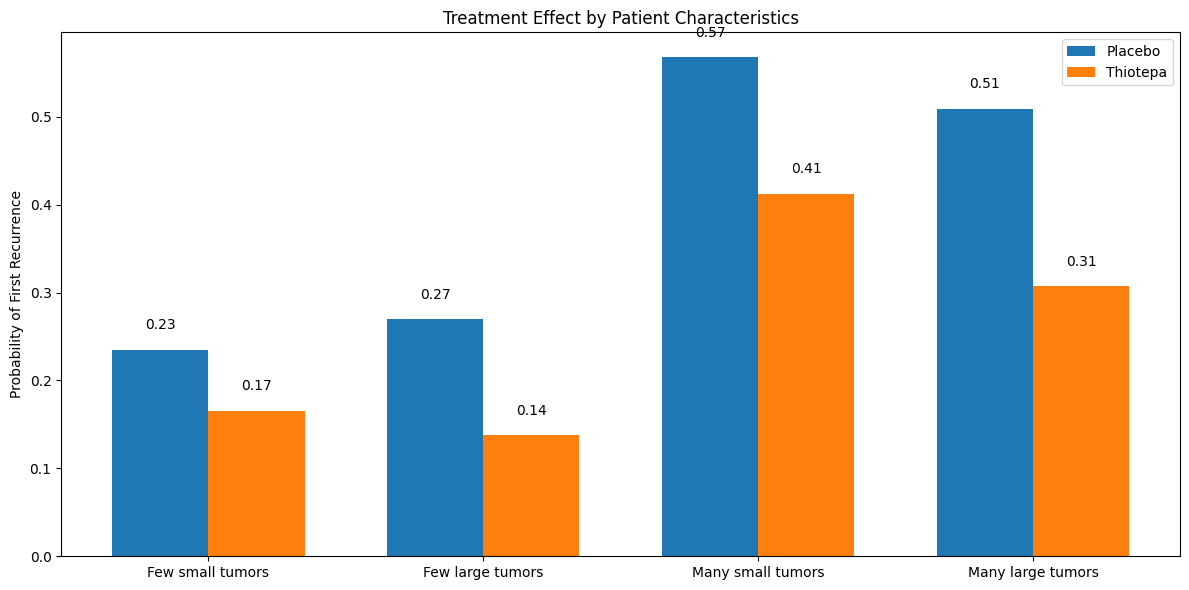

In [24]:
# Create a set of profiles with and without treatment
profiles_base = [
    [-0.5, -0.5],  # Few small tumors
    [-0.5, 1.0],   # Few large tumors
    [1.0, -0.5],   # Many small tumors
    [1.0, 1.0],    # Many large tumors
]

# Create placebo/thiotepa profiles
placebo_profiles = [[1.0] + p for p in profiles_base]  # rx=1.0 (placebo)
thiotepa_profiles = [[2.0] + p for p in profiles_base]  # rx=2.0 (thiotepa)

# Convert to tensors
placebo_tensor = torch.tensor(placebo_profiles, dtype=torch.float32)
thiotepa_tensor = torch.tensor(thiotepa_profiles, dtype=torch.float32)

# Get predictions for transition to first recurrence
placebo_probs = deterministic_model.predict_proba(placebo_tensor, time_start=0.0, time_end=12.0, from_state=0)
thiotepa_probs = deterministic_model.predict_proba(thiotepa_tensor, time_start=0.0, time_end=12.0, from_state=0)

# Extract probabilities for first recurrence (State 1)
placebo_recur_probs = placebo_probs[:, 1].detach().numpy()
thiotepa_recur_probs = thiotepa_probs[:, 1].detach().numpy()

# Create labels for the profiles
profile_labels = [
    "Few small tumors",
    "Few large tumors",
    "Many small tumors",
    "Many large tumors",
]

# Plot the comparison
width = 0.35
x = np.arange(len(profile_labels))

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, placebo_recur_probs, width, label='Placebo')
bars2 = ax.bar(x + width/2, thiotepa_recur_probs, width, label='Thiotepa')

ax.set_ylabel('Probability of First Recurrence')
ax.set_title('Treatment Effect by Patient Characteristics')
ax.set_xticks(x)
ax.set_xticklabels(profile_labels)
ax.legend()

# Add value labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}', ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

fig.tight_layout()
plt.show()

## Conclusions

In this notebook, we've demonstrated how to use MultiStateNN to model bladder cancer recurrence patterns. We've shown how to:

1. Prepare bladder cancer data for multistate modeling
2. Train both deterministic and Bayesian multistate neural network models
3. Make predictions for different patient profiles
4. Visualize the transition probabilities and recurrence networks
5. Analyze the effects of key covariates (treatment, number of tumors, tumor size)
6. Simulate patient trajectories with time adjustment to ensure consistent predictions
7. Calculate cumulative incidence functions (CIFs) using the Aalen-Johansen estimator
8. Compare the deterministic and Bayesian modeling approaches

Key findings:
- Treatment with thiotepa generally lowers the probability of recurrence
- The number and size of initial tumors are important risk factors
- Patient profiles with more and larger tumors show faster progression through recurrence states
- Bayesian modeling provides a framework for representing uncertainty in predictions
- Time-adjusted simulations provide more accurate CIF estimates, especially when comparing different models or patient groups
- The Aalen-Johansen estimator handles competing risks appropriately in the multistate framework

For further analysis, we could extend this approach to incorporate more clinical covariates, explore different neural network architectures, or develop personalized risk prediction tools for patient counseling.

## Note on CIF Calculation

For accurate and consistent CIF calculations, we used:

1. **Time-adjusted simulations** - By setting `time_adjusted=True`, we ensure that the transition probabilities are properly adjusted for the time step size, making CIF calculations consistent regardless of the time discretization.

2. **Aalen-Johansen estimator** - Using `method="aalen-johansen"` in the calculate_cif function ensures proper handling of competing risks, which is essential in multistate models where patients can transition to multiple different states.

3. **Consistent time grid** - We evaluated all CIFs on the same time grid using the `time_grid` parameter, which ensures valid comparisons between different patient profiles.